In [1]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（ペア＋単粒子遷移含む）
w3 = 0.2      # 3体相互作用

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義 ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン（改訂版）====
pairs = [(0, 1), (2, 3), (4, 5)]
H2 = np.zeros((dim, dim))

def find_pair_and_single(state):
    """3粒子状態から (pair_index, single_orbital) を特定"""
    for p_idx, (a, b) in enumerate(pairs):
        if state[a] == 1 and state[b] == 1:
            s = [i for i in range(len(state)) if state[i] == 1 and i not in (a, b)][0]
            return p_idx, s
    return None, None

# すべてのペア・単粒子遷移を許す
for i, bra in enumerate(basis):
    p_bra, s_bra = find_pair_and_single(bra)
    if p_bra is None:
        continue  # ペアがない状態は作用しない

    for j, ket in enumerate(basis):
        p_ket, s_ket = find_pair_and_single(ket)
        if p_ket is None:
            continue

        # ペアと単粒子の両方が遷移できる
        # 全結合を許して同一強度v
        H2[i, j] += v



# ==== 3体ハミルトニアン（変更なし）====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # アニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # クリエイト
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = (H + H.conj()) / 2  # Hermitian化

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))
print(H)

# ==== 固有値 ====
eigvals, _ = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

print("\nNonzero elements in H2:", np.count_nonzero(H2))

Hamiltonian matrix (dim=20):
[[1.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.3 1.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 2.3 0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 2.3 0.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.3 0.3 0.3 0.3 2.3 0.  0.  0.  0.  0.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  3.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. ]
 [0.3 0.3 0.3 0.3 0.3 0.  0.  0.  0.  4.3 0.3 0.  0.  0.  0.  0.3 0.3 0.3
  0.3 0.3]
 [0.5 0.3 0.3 0.3 0.3 0.  0.  0.  0.  0.3 2.5 0.  0.  0.  0.  0.3 0.5 0.3
  0.3 0.5]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit.circuit.library import QFT, StatePreparation
from qiskit_aer import Aer

n_sys = 5                    
dim = len(basis)            

evals, evecs = np.linalg.eigh(H) 

def U_embed(time):
    phases = np.exp(-1j * evals * time)
    U20 = (evecs @ np.diag(phases) @ evecs.conj().T)
    U32 = np.eye(2**n_sys, dtype=complex)
    U32[:dim, :dim] = U20
    return UnitaryGate(U32, label=f"e^(-iHt), t={time:g}")

psi0 = None

use_ground_state_prep = True
prep = None
if use_ground_state_prep:
    gvec20 = evecs[:, 0]                       
    gvec32 = np.zeros(2**n_sys, dtype=complex)
    gvec32[:dim] = gvec20
    prep = StatePreparation(gvec32)

def qpe_energy(H_evals, num_eval_qubits=10, shots=4096, t=None, psi_prep=None):
    Emax = float(np.max(np.abs(H_evals)))
    if t is None:
        t = np.pi / (2.0 * max(Emax, 1e-12))

    qr_anc = QuantumRegister(num_eval_qubits, "anc")
    qr_sys = QuantumRegister(n_sys, "sys")
    cr = ClassicalRegister(num_eval_qubits, "c")
    qc = QuantumCircuit(qr_anc, qr_sys, cr)

    if psi_prep is not None:
        qc.append(psi_prep, qr_sys)

    qc.h(qr_anc)

    for k in range(num_eval_qubits):
        Uk = U_embed(t * (2**k)).control(1)
        qc.append(Uk, [qr_anc[k], *qr_sys])

    iqft = QFT(num_eval_qubits, do_swaps=True).inverse()
    qc.append(iqft, qr_anc)

    qc.measure(qr_anc, cr)

    backend = Aer.get_backend("aer_simulator")
    tqc = transpile(qc, backend)
    res = backend.run(tqc, shots=shots).result()
    counts = res.get_counts()

    bitstring = max(counts, key=counts.get)
    k = int(bitstring, 2)     
    phi = k / (2**num_eval_qubits)
    theta = 2*np.pi*phi
    if theta > np.pi:         
        theta -= 2*np.pi
    E_est = - theta / t       


    return {"energy": E_est, "phase": phi, "bitstring": bitstring, "t": t,
            "counts": counts, "circuit": qc}

out = qpe_energy(evals, num_eval_qubits=10, shots=8192, t=None, psi_prep=prep)
print("=== QPE (matrix-embedding) ===")
print("bitstring :", out["bitstring"])
print("phase     :", out["phase"])
print("t         :", out["t"])
print("E (est.)  :", out["energy"])
print("E (exact) :", evals[0])


/tmp/ipykernel_696509/84984544.py:64: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft = QFT(num_eval_qubits, do_swaps=True).inverse()


=== QPE (matrix-embedding) ===
bitstring : 1111011011
phase     : 0.9638671875
t         : 0.21199717923476635
E (est.)  : 1.0709064970891051
E (exact) : 1.0640651047761234


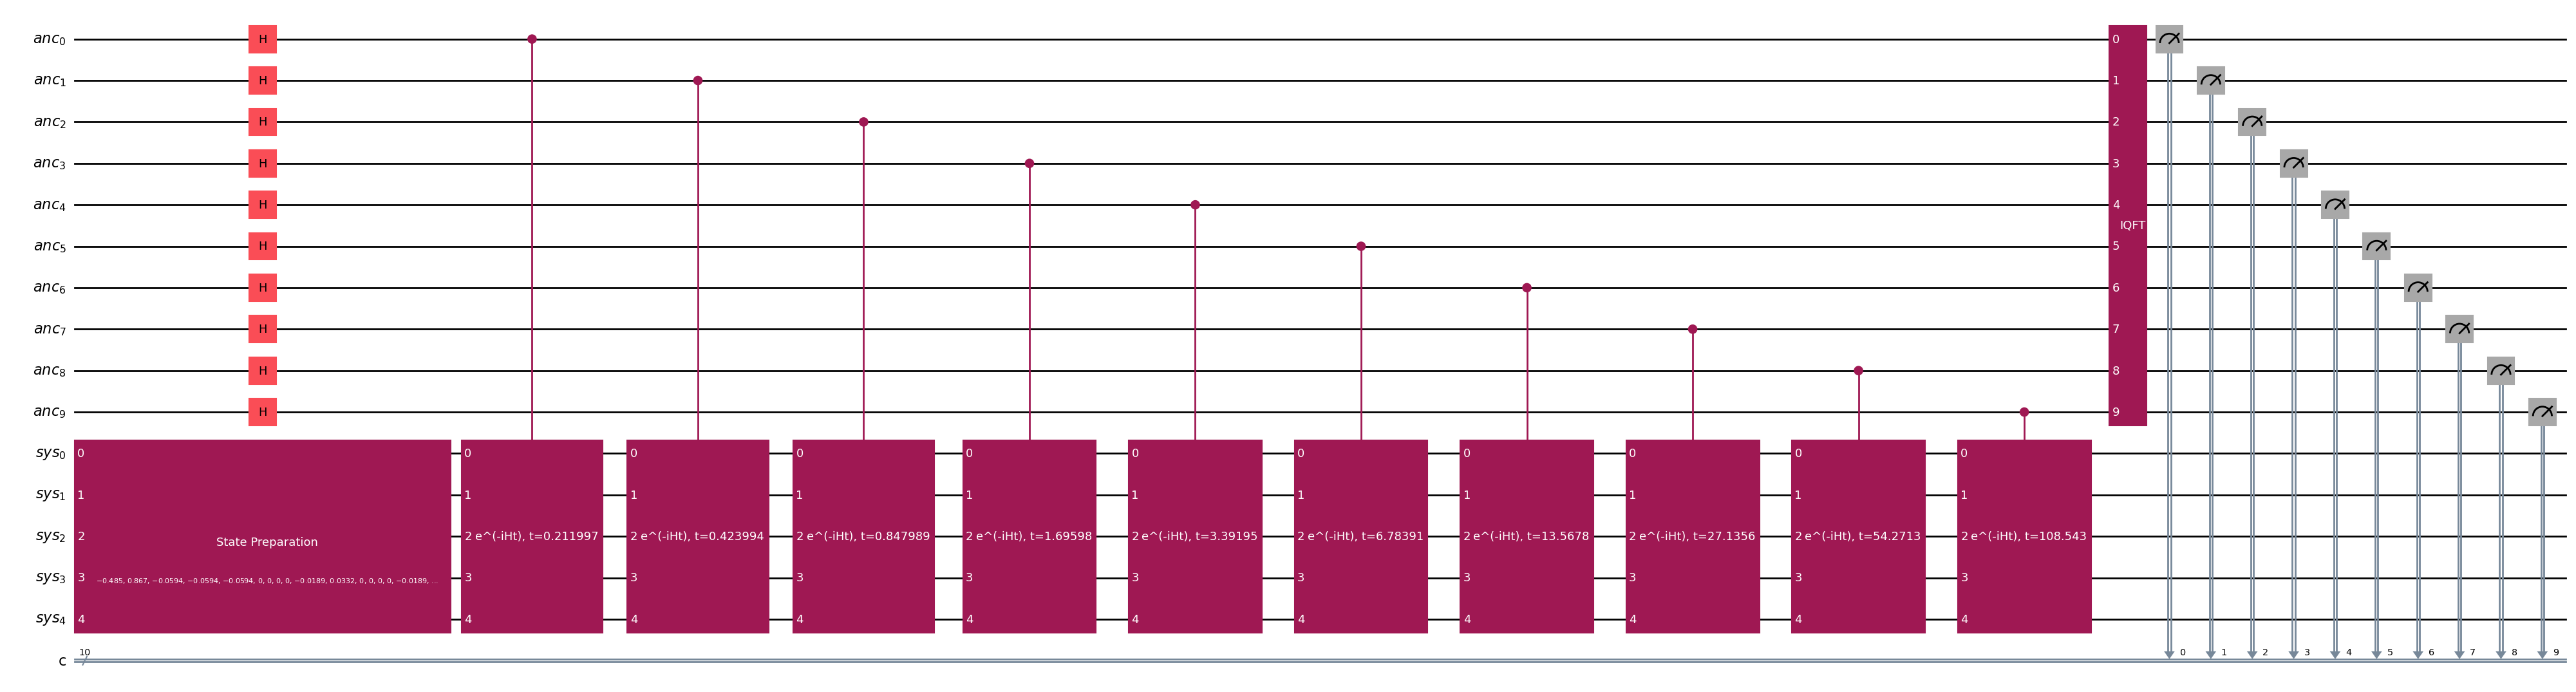

In [ ]:
out["circuit"].draw(
    output="mpl",
    fold=-1
)